In [1]:
!git clone https://github.com/kdkalvik/skeleton-action-recognition
%cd skeleton-action-recognition
%pip install -r requirements.txt

fatal: destination path 'skeleton-action-recognition' already exists and is not an empty directory.
/content/skeleton-action-recognition


In [2]:
import torch
import torchvision
from utils import *
from skimage.transform import resize
from layers.virtual_radar import VirtualRadar
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['image.cmap'] = 'jet'

(8192, 17, 3)
STFT kernels created, time used = 0.0281 seconds
(256, 5121)
-8.6799345 7.7528853


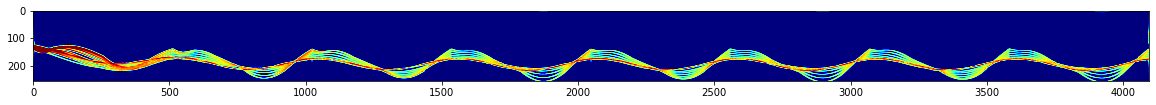

In [3]:
# load simulated gait data
edges = [(0, 1), (1, 2), (1, 3), (3, 5), (5, 7), (1, 4), (4, 6), (6, 8), (0, 9), 
         (9, 11), (11, 13), (13, 15), (0, 10), (10, 12), (12, 14), (14, 16)]
sim_data = np.load("data/simulated_gait.npy")
print(sim_data.shape)
sim_data = pad_frames(sim_data, num_pad_frames=10)
sim_data = sim_data.transpose(2, 0, 1)
sim_data = np.expand_dims(sim_data, axis=[0, -1])
sim_data = torch.Tensor(sim_data)

virtual_radar = VirtualRadar(edges=edges, wavelength=5e-4, device='cpu')
spectrogram = virtual_radar(sim_data).data.numpy()[0]
print(spectrogram.shape)
spectrogram = resize(spectrogram, (256, 4096))
print(spectrogram.min(), spectrogram.max())
plt.imshow(spectrogram, clim=[0, 5])

(300, 25, 3)
STFT kernels created, time used = 0.0074 seconds
(256, 10313)
-13.815511 8.798811


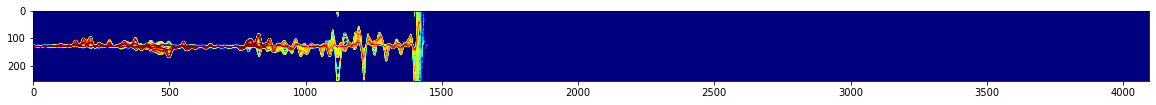

In [4]:
# load NTU data
ntu_data = np.load("data/NTU_preprocessed_skeleton_examples.npy")[0, :, :, :, 0]
ntu_data = np.transpose(ntu_data, (1, 2, 0))
print(ntu_data.shape)
ntu_data = pad_frames(ntu_data, num_pad_frames=550)
ntu_data = ntu_data.transpose(2, 0, 1)
ntu_data = np.expand_dims(ntu_data, axis=[0, -1])
ntu_data = torch.Tensor(ntu_data)

# generate spectrogram
virtual_radar = VirtualRadar(wavelength=9e-4, device='cpu')
spectrogram = virtual_radar(ntu_data).data.numpy()[0]
print(spectrogram.shape)
spectrogram = resize(spectrogram, (256, 4096))
print(spectrogram.min(), spectrogram.max())
plt.imshow(spectrogram, clim=[0, 6])

In [5]:
# load azure kinect data
data, edges = preprocess_azure_kinect("data/sim_data.json")
data = pad_frames(data, num_pad_frames=550)
data = data.transpose(2, 0, 1)
data = np.expand_dims(data, axis=[0, -1])
data = torch.Tensor(data)

STFT kernels created, time used = 0.0194 seconds
(256, 10141)
-8.872429 7.288475


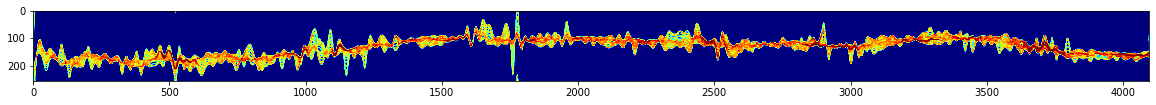

In [6]:
# generate spectrogram
virtual_radar = VirtualRadar(edges=edges, wavelength=9e-4, device='cpu')
spectrogram = virtual_radar(data).data.numpy()[0]
print(spectrogram.shape)
spectrogram = resize(spectrogram, (256, 4096))
print(spectrogram.min(), spectrogram.max())
plt.imshow(spectrogram, clim=[0, 4])

(256, 10141)
-6.795711 8.767012


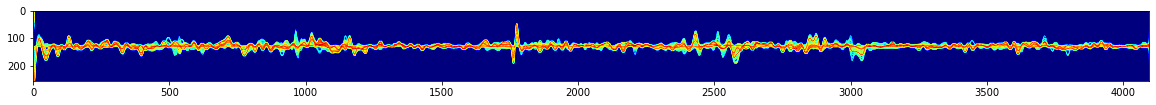

In [7]:
# generate spectrogram for data with skeleton centered at origin for all frames
data_spine_center = data - data[:, :, :, 0:1, :]
spectrogram = virtual_radar(data_spine_center).data.numpy()[0]
print(spectrogram.shape)
spectrogram = resize(spectrogram, (256, 4096))
print(spectrogram.min(), spectrogram.max())
plt.imshow(spectrogram, clim=[0, 8])

STFT kernels created, time used = 0.0077 seconds
(512, 10142)
-102.36064 26.550339


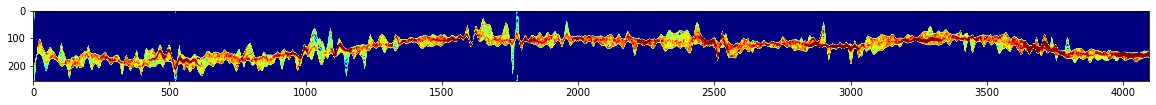

In [8]:
##Check if pytorch stft matches scipy stft 

import torch
import numpy as np
from nnAudio.Spectrogram import STFT
from scipy import signal

class VirtualRadarScipy(VirtualRadar):
    def forward(self, x):
        """
        Computes forward propogation of the layer
        Args:
           x: A tensor with shape
                    (batch_size, num_features, timesteps, vertices, num_graphs)
              num_features: 3, (x, y, z) coordinates of each vertex.
              num_graphs: 1 or higher, number of seperate graph entities present
                in the data.
                example: If each graph modeled a human skeleton, radar return
                    generated from multiple humans can be superimposed onto
                    the same Spectrogram.
        """

        source_joints = x[:, :, :, self.src]
        destination_joints = x[:, :, :, self.dst]

        radar_ellipsoid_vector = torch.abs(source_joints -
                                           self.radar_location[:, None, None,
                                                               None])
        distances = torch.norm(radar_ellipsoid_vector, dim=1)

        A = self.radar_location[:, None, None, None]-\
                ((source_joints+destination_joints)/2)
        B = destination_joints - source_joints
        theta = torch.acos(torch.sum(A*B, dim=1) /\
                        ((torch.norm(A, dim=1) * torch.norm(B, dim=1))+1e-6))
        phi = torch.asin(
            (self.radar_location[1] - source_joints[:, 1]) /
            (torch.norm(radar_ellipsoid_vector[:, :2], dim=1) + 1e-6))

        c = torch.mean(torch.norm(source_joints - destination_joints, dim=1),
                       dim=2,
                       keepdim=True)
        c = torch.pow(c, 2)
        rcs = (np.pi*c)/((torch.sin(theta)**2)*(torch.cos(phi)**2) + \
                         (torch.sin(theta)**2)*(torch.sin(phi)**2) + \
                       c*(torch.cos(theta)**2))**2

        amp = torch.sqrt(rcs)
        theta = 4 * np.pi * distances / self.wavelength

        phase_data = torch.stack(
            (amp * torch.cos(theta), amp * torch.sin(theta)), dim=4)
        phase_data = torch.sum(phase_data, dim=[2, 3])[0]
        phase_data = phase_data[:, 1].data.numpy()*1j + phase_data[:, 0].data.numpy() 
        _, _, phase_data = signal.stft(phase_data,
                              window=signal.gaussian(512, std=16),
                              nperseg=512,
                              noverlap=512-16,
                              nfft=512,
                              return_onesided=False)

        phase_data = np.fft.fftshift(np.abs(phase_data), 0)
        phase_data = 20*np.log10(phase_data+1e-6)
        return phase_data

# geenrate spectrogram
virtual_radar_scipy = VirtualRadarScipy(edges=edges, wavelength=9e-4, device='cpu')
spectrogram_scipy = virtual_radar_scipy(data)
print(spectrogram_scipy.shape)
spectrogram_scipy = resize(spectrogram_scipy, (256, 4096))
print(spectrogram_scipy.min(), spectrogram_scipy.max())

plt.imshow(spectrogram_scipy, clim=[-30, -5])